In [1]:
!pip install 'plenopticam>=0.7.0'

ERROR: Invalid requirement: "'plenopticam"


In [7]:
#!/usr/bin/env python

__author__ = "Christopher Hahne"
__email__ = "info@christopherhahne.de"
__license__ = """
    Copyright (c) 2017 Christopher Hahne <info@christopherhahne.de>

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

"""

# local imports
from plenopticam import misc
from plenopticam.lfp_aligner.lfp_resampler import LfpResampler
from plenopticam.lfp_aligner.lfp_rotator import LfpRotator
from plenopticam.lfp_aligner.cfa_outliers import CfaOutliers
from plenopticam.lfp_aligner.cfa_processor import CfaProcessor
from plenopticam.lfp_aligner.lfp_devignetter import LfpDevignetter


class LfpAlignerModified(object):

    def __init__(self, lfp_img, cfg=None, sta=None, wht_img=None):

        # input variables
        self.cfg = cfg
        self.sta = sta if sta is not None else misc.PlenopticamStatus()
        self._lfp_img = lfp_img.astype('float') if lfp_img is not None else None
        self._wht_img = wht_img.astype('float') if wht_img is not None else None

    def main(self):

        if self.cfg.lfpimg:
            # hot pixel correction
            obj = CfaOutliers(bay_img=self._lfp_img, cfg=self.cfg, sta=self.sta)
            obj.rectify_candidates_bayer(n=9, sig_lev=2.5)
            self._lfp_img = obj.bay_img
            del obj

        if self.cfg.params[self.cfg.opt_vign] and self._wht_img is not None:
            # apply de-vignetting
            obj = LfpDevignetter(lfp_img=self._lfp_img, wht_img=self._wht_img, cfg=self.cfg, sta=self.sta)
            obj.main()
            self._lfp_img = obj.lfp_img
            self._wht_img = obj.wht_img
            del obj

      #  if self.cfg.lfpimg and len(self._lfp_img.shape) == 2:
            # perform color filter array management and obtain rgb image
       #     cfa_obj = CfaProcessor(bay_img=self._lfp_img, wht_img=self._wht_img, cfg=self.cfg, sta=self.sta)
        #    cfa_obj.main()
         #   self._lfp_img = cfa_obj.rgb_img
          #  del cfa_obj

        if self.cfg.params[self.cfg.opt_rota] and self._lfp_img is not None:
            # de-rotate centroids
            obj = LfpRotator(self._lfp_img, self.cfg.calibs[self.cfg.mic_list], rad=None, cfg=self.cfg, sta=self.sta)
            obj.main()
            self._lfp_img, self.cfg.calibs[self.cfg.mic_list] = obj.lfp_img, obj.centroids
            del obj

        # interpolate each micro image with its MIC as the center with consistent micro image size
        obj = LfpResamplerModified(lfp_img=self._lfp_img, cfg=self.cfg, sta=self.sta, method='linear')
        obj.main()
        self._lfp_img = obj.lfp_out
        del obj

        return True

    @property
    def lfp_img(self):
        return self._lfp_img.copy()


In [8]:
# local imports
from plenopticam import misc
from plenopticam.misc.type_checks import rint
from plenopticam.lfp_aligner.lfp_microlenses import LfpMicroLenses

# external libs
import numpy as np
import os
import pickle
import functools
from scipy.interpolate import interp2d, RectBivariateSpline


class LfpResamplerModified(LfpMicroLenses):

    def __init__(self, *args, **kwargs):
        super(LfpResamplerModified, self).__init__(*args, **kwargs)

        # interpolation method initialization
        method = kwargs['method'] if 'method' in kwargs else None
        method = method if method in ['nearest', 'linear', 'cubic', 'quintic'] else None
        method = 'cubic' if method == 'quintic' and self._M < 5 else method
        interp2d_method = functools.partial(interp2d, kind=method) if method is not None else interp2d

        if method is None:
            self._interpol_method = RectBivariateSpline
        elif method == 'nearest':
            self._interpol_method = self._nearest
        else:
            self._interpol_method = interp2d_method

        # output variable
        self._lfp_out = np.zeros(self._lfp_img.shape) if self._lfp_img is not None else None

    def main(self):
        """ cropping micro images to square shape while interpolating around their detected center (MIC) """

        # check interrupt status
        if self.sta.interrupt:
            return False

        # print status
        self.sta.status_msg('Light-field alignment', self.cfg.params[self.cfg.opt_prnt])

        # start resampling process (taking micro lens arrangement into account)
        if self.cfg.calibs[self.cfg.pat_type] == 'rec':
            self.resample_rec()
        elif self.cfg.calibs[self.cfg.pat_type] == 'hex':
            self.resample_hex()

        # save aligned image to hard drive
        self._write_lfp_align()

        return True

    def _write_lfp_align(self):

        # print status
        self.sta.status_msg('Save aligned light-field', self.cfg.params[self.cfg.opt_prnt])
        self.sta.progress(None, self.cfg.params[self.cfg.opt_prnt])

        # convert to 16bit unsigned integer
        self._lfp_out = misc.Normalizer(self._lfp_out).uint16_norm()

        # create output data folder
        misc.mkdir_p(self.cfg.exp_path, self.cfg.params[self.cfg.opt_prnt])

        # write aligned light field as pickle file to avoid re-calculation
        with open(os.path.join(self.cfg.exp_path, 'lfp_img_align.pkl'), 'wb') as f:
            pickle.dump(self._lfp_out, f)

        if self.cfg.params[self.cfg.opt_dbug]:
            misc.save_img_file(self._lfp_out, os.path.join(self.cfg.exp_path, 'lfp_img_align.tiff'))

        self.sta.progress(100, self.cfg.params[self.cfg.opt_prnt])

    def _patch_align(self, window, mic):

        # initialize patch
        patch = np.zeros(window.shape)
        

        # verify patch shapes as wrong shapes cause crashes
        if window.shape[0] == self._M+2 and window.shape[1] == self._M+2:
            # iterate through color channels
           # for p in range(self._DIMS[2]):

                fun = self._interpol_method(range(window.shape[1]), range(window.shape[0]), window[:, :])

                patch[:, :] = fun(np.arange(window.shape[1])+mic[1]-rint(mic[1]),
                                     np.arange(window.shape[0])+mic[0]-rint(mic[0]))
        else:
            self.sta.status_msg('Warning: chosen micro image size exceeds light-field borders')
            return np.zeros((self._M+2,)*2+(window.shape[2],))

        # flip patch to compensate for micro lens rotation
        patch = np.flip(patch, axis=(0, 1)) if self._flip else patch

        return patch

    def _nearest(self, range0, range1, window):

        def shift_win(shifted_range0, shifted_range1):
            range0 = np.round(shifted_range0).astype('int')
            range1 = np.round(shifted_range1).astype('int')
            return window[range0[0]:range0[-1]+1, range1[0]:range0[-1]+1]

        return shift_win

    def resample_rec(self):

        # initialize variables required for micro image resampling process
        self._lfp_out = np.zeros([self._LENS_Y_MAX * self._M, self._LENS_X_MAX * self._M, self._DIMS[2]])

        # iterate over each MIC
        for ly in range(self._LENS_Y_MAX):
            for lx in range(self._LENS_X_MAX):

                # find MIC by indices
                mic = self.get_coords_by_idx(ly=ly, lx=lx)

                # interpolate each micro image with its MIC as the center with consistent micro image size
                window = self._lfp_img[rint(mic[0])-self._C-1:rint(mic[0])+self._C+2,
                                       rint(mic[1])-self._C-1:rint(mic[1])+self._C+2]
                self._lfp_out[ly*self._M:(ly+1)*self._M, lx*self._M:(lx+1)*self._M] = \
                    self._patch_align(window, mic)[1:-1, 1:-1]

            # check interrupt status
            if self.sta.interrupt:
                return False

            # print progress status for on console
            self.sta.progress((ly + 1) / self._LENS_Y_MAX * 100, self.cfg.params[self.cfg.opt_prnt])

        return True

    def resample_hex(self):

        # initialize variables required for micro image resampling process
        patch_stack = np.zeros([self._LENS_X_MAX, self._M, self._M])
        hex_stretch = int(np.round(2 * self._LENS_X_MAX / np.sqrt(3)))
        interp_stack = np.zeros([hex_stretch, self._M, self._M])
        self._lfp_out = np.zeros([self._LENS_Y_MAX * self._M, hex_stretch * self._M])

        # check if lower neighbor of upper left MIC is shifted to left or right
        hex_odd = self.get_hex_direction(self._CENTROIDS)

        # iterate over each MIC
        for ly in range(self._LENS_Y_MAX):
            for lx in range(self._LENS_X_MAX):

                # find MIC by indices
                mic = self.get_coords_by_idx(ly=ly, lx=lx)

                # interpolate each micro image with its MIC as the center and consistent micro image size
                window = self._lfp_img[rint(mic[0])-self._C-1:rint(mic[0])+self._C+2,
                                       rint(mic[1])-self._C-1:rint(mic[1])+self._C+2]
                patch_stack[lx, :] = self._patch_align(window, mic)[1:-1, 1:-1]

            # image stretch interpolation in x-direction to compensate for hex-alignment
            for y in range(self._M):
                for x in range(self._M):
                    #for p in range(self._DIMS[2]):
                        # stack of micro images elongated in x-direction
                        interp_coords = np.linspace(0, self._LENS_X_MAX, int(np.round(self._LENS_X_MAX*2/np.sqrt(3))))+\
                                        .5*np.mod(ly+hex_odd, 2)
                        interp_stack[:, y, x] = np.interp(interp_coords, range(self._LENS_X_MAX), patch_stack[:, y, x])

            self._lfp_out[ly*self._M:(ly+1)*self._M, :] = \
                np.concatenate(interp_stack, axis=1).reshape((self._M, hex_stretch*self._M))

            # check interrupt status
            if self.sta.interrupt:
                return False

            # print progress status
            self.sta.progress((ly+1) / self._LENS_Y_MAX * 100, self.cfg.params[self.cfg.opt_prnt])

    @property
    def lfp_out(self):
        return self._lfp_out.copy()

In [9]:
#!/usr/bin/env python

__author__ = "Christopher Hahne"
__email__ = "info@christopherhahne.de"
__license__ = """
    Copyright (c) 2019 Christopher Hahne <info@christopherhahne.de>

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

"""

import numpy as np

from plenopticam.lfp_extractor import LfpViewpoints
from plenopticam.misc import PlenopticamError


class LfpRearrangerModified(LfpViewpoints):

    def __init__(self, lfp_img_align=None, *args, **kwargs):
        super(LfpRearrangerModified, self).__init__(*args, **kwargs)

        self._lfp_img_align = lfp_img_align if lfp_img_align is not None else None
        self._dtype = self._lfp_img_align.dtype if self._lfp_img_align is not None else self._vp_img_arr.dtype

    def _init_vp_img_arr(self):
        """ initialize viewpoint output image array """

        if len(self._lfp_img_align.shape) == 3:
            m, n, p = self._lfp_img_align.shape
        elif len(self._lfp_img_align.shape) == 2:
            m, n, p = self._lfp_img_align.shape[:2] + (1,)
        else:
            raise PlenopticamError('Dimensions %s of provided light-field not supported', self._lfp_img_align.shape,
                                   cfg=self.cfg, sta=self.sta)

        self._vp_img_arr = np.zeros([int(self._M), int(self._M), int(m/self._M), int(n/self._M)], dtype=self._dtype)

    def _init_lfp_img_align(self):
        """ initialize micro image output image array """

        if len(self._vp_img_arr.shape) == 4:
            m, n, p = self._vp_img_arr.shape[2:]
        elif len(self._vp_img_arr.shape) == 3:
            m, n, p = self._vp_img_arr.shape[2:] + (1,)
        else:
            raise PlenopticamError('Dimensions %s of provided light-field not supported', self._vp_img_arr.shape,
                                   cfg=self.cfg, sta=self.sta)

        m *= self._vp_img_arr.shape[0]
        n *= self._vp_img_arr.shape[1]

        # create empty array
        self._lfp_img_align = np.zeros([m, n], dtype=self._dtype)

        # update angular resolution parameter
        self._M = self._vp_img_arr.shape[0] if self._vp_img_arr.shape[0] == self._vp_img_arr.shape[1] else float('inf')

    def main(self):

        # check interrupt status
        if self.sta.interrupt:
            return False

        # rearrange light-field to viewpoint representation
        self.compose_viewpoints()

    def compose_viewpoints(self):
        """
        Conversion from aligned micro image array to viewpoint array representation. The fundamentals behind the
        4-D light-field transfer were derived by Levoy and Hanrahans in their paper 'Light Field Rendering' in Fig. 6.
        """

        # print status
        self.sta.status_msg('Viewpoint composition', self.cfg.params[self.cfg.opt_prnt])
        self.sta.progress(None, self.cfg.params[self.cfg.opt_prnt])

        # initialize basic light-field parameters
        self._init_vp_img_arr()

        # rearrange light field to multi-view image representation
        for j in range(self._M):
            for i in range(self._M):

                # check interrupt status
                if self.sta.interrupt:
                    return False

                # extract viewpoint by pixel rearrangement
                self._vp_img_arr[j, i] = self._lfp_img_align[j::self._M, i::self._M]

                # print status
                percentage = (j*self._M+i+1)/self._M**2
                self.sta.progress(percentage*100, self.cfg.params[self.cfg.opt_prnt])

        return True

    def decompose_viewpoints(self):
        """
        Conversion from viewpoint image array to aligned micro image array representation. The fundamentals behind the
        4-D light-field transfer were derived by Levoy and Hanrahans in their paper 'Light Field Rendering' in Fig. 6.
        """

        # print status
        self.sta.status_msg('Viewpoint decomposition', self.cfg.params[self.cfg.opt_prnt])
        self.sta.progress(None, self.cfg.params[self.cfg.opt_prnt])

        # initialize basic light-field parameters
        self._init_lfp_img_align()

        # rearrange light field to multi-view image representation
        for j in range(self._M):
            for i in range(self._M):

                # check interrupt status
                if self.sta.interrupt:
                    return False

                # extract viewpoint by pixel rearrangement
                self._lfp_img_align[j::self._M, i::self._M] = self._vp_img_arr[j, i, :, :, :]

                # print status
                percentage = (j*self._M+i+1)/self._M**2
                self.sta.progress(percentage*100, self.cfg.params[self.cfg.opt_prnt])

        return True


In [10]:
#!/usr/bin/env python

__author__ = "Christopher Hahne"
__email__ = "info@christopherhahne.de"
__license__ = """
    Copyright (c) 2017 Christopher Hahne <info@christopherhahne.de>

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

"""

# local imports
from plenopticam.cfg import PlenopticamConfig
from plenopticam import misc
from plenopticam.lfp_extractor.lfp_cropper import LfpCropper
from plenopticam.lfp_extractor.lfp_rearranger import LfpRearranger
from plenopticam.lfp_extractor.lfp_exporter import LfpExporter
from plenopticam.lfp_extractor.lfp_contrast import LfpContrast
from plenopticam.lfp_extractor.lfp_outliers import LfpOutliers
from plenopticam.lfp_extractor.lfp_color_eq import LfpColorEqualizer
from plenopticam.lfp_extractor.hex_corrector import HexCorrector
from plenopticam.lfp_extractor.lfp_depth import LfpDepth

import pickle
import os


class LfpExtractorModified(object):

    def __init__(self, lfp_img_align=None, cfg=None, sta=None):

        # input variables
        self._lfp_img_align = lfp_img_align
        self.cfg = cfg if cfg is not None else PlenopticamConfig()
        self.sta = sta if sta is not None else misc.PlenopticamStatus()

        # variables for viewpoint arrays
        self.vp_img_arr = []        # gamma corrected
        self.vp_img_linear = []     # linear gamma (for further processing)
        self.depth_map = None

    def main(self):

        # load previously calculated calibration and aligned data
        self.cfg.load_cal_data()
        if self._lfp_img_align is None:
            self.load_pickle_file()
            self.load_lfp_metadata()

        # micro image crop
        lfp_obj = LfpCropper(lfp_img_align=self._lfp_img_align, cfg=self.cfg, sta=self.sta)
        lfp_obj.main()
        self._lfp_img_align = lfp_obj.lfp_img_align
        del lfp_obj

        # rearrange light-field to sub-aperture images
        if self.cfg.params[self.cfg.opt_view]:
            lfp_obj = LfpRearrangerModified(self._lfp_img_align, cfg=self.cfg, sta=self.sta)
            lfp_obj.main()
            self.vp_img_linear = lfp_obj.vp_img_arr
            del lfp_obj

        # remove outliers if option is set
        if self.cfg.params[self.cfg.opt_lier]:
            obj = LfpOutliers(vp_img_arr=self.vp_img_linear, cfg=self.cfg, sta=self.sta)
            obj.main()
            self.vp_img_linear = obj.vp_img_arr
            del obj

#         # color equalization
#         if self.cfg.params[self.cfg.opt_colo]:
#             obj = LfpColorEqualizer(vp_img_arr=self.vp_img_linear, cfg=self.cfg, sta=self.sta)
#             obj.main()
#             self.vp_img_linear = obj.vp_img_arr
#             del obj

        # copy light-field for refocusing process prior to contrast alignment and export
        self.vp_img_arr = self.vp_img_linear.copy() if self.vp_img_linear is not None else None

#         # color management automation
#         obj = LfpContrast(vp_img_arr=self.vp_img_arr, cfg=self.cfg, sta=self.sta)
#         obj.main()
#         self.vp_img_arr = obj.vp_img_arr
#         del obj

        # reduction of hexagonal sampling artifacts
        if self.cfg.params[self.cfg.opt_arti]:
            obj = HexCorrector(vp_img_arr=self.vp_img_arr, cfg=self.cfg, sta=self.sta)
            obj.main()
            self.vp_img_arr = obj.vp_img_arr
            del obj

        # write viewpoint data to hard drive
        if self.cfg.params[self.cfg.opt_view]:
            obj = LfpExporter(vp_img_arr=self.vp_img_arr, cfg=self.cfg, sta=self.sta)
            obj.write_viewpoint_data()
            del obj

        # compute and write depth data from epipolar analysis
#         if self.cfg.params[self.cfg.opt_dpth]:
#             obj = LfpDepth(vp_img_arr=self.vp_img_arr, cfg=self.cfg, sta=self.sta)
#             obj.main()
#             self.depth_map = obj.depth_map
#             del obj

        return True

    def load_pickle_file(self):
        """ load previously computed light field alignment """

        # file path
        fp = os.path.join(self.cfg.exp_path, 'lfp_img_align.pkl')

        try:
            self._lfp_img_align = pickle.load(open(fp, 'rb'))
        except EOFError:
            os.remove(fp)
        except FileNotFoundError:
            return False

        return True

    def load_lfp_metadata(self):
        """ load LFP metadata settings (for Lytro files only) """

        fname = os.path.splitext(os.path.basename(self.cfg.params[self.cfg.lfp_path]))[0]+'.json'
        fp = os.path.join(self.cfg.exp_path, fname)
        if os.path.isfile(fp):
            json_dict = self.cfg.load_json(fp=fp, sta=None)
            from plenopticam.lfp_reader.lfp_decoder import LfpDecoder
            self.cfg.lfpimg = LfpDecoder().filter_lfp_json(json_dict, settings=self.cfg.lfpimg)

        return True


In [11]:
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl

try:
	import plenopticam as pcam
except ImportError:
	print('run-> python3 -m pip install plenopticam>=0.7.0')

def lf_decode_sans_save(lfp_path, cal_path, full_sai = True, central_view_extract_dim = 3):
	#Configuration
	cfg = pcam.cfg.PlenopticamConfig()
	cfg.default_values()
	cfg.params[cfg.lfp_path] = lfp_path
	cfg.params[cfg.cal_path] = cal_path
	cfg.params[cfg.opt_cali] = True
	cfg.params[cfg.ptc_leng] = 13
	cfg.params[cfg.cal_meth] = pcam.cfg.constants.CALI_METH[3]
	cfg.params[cfg.opt_cont]=False
	cfg.params[cfg.opt_colo]=False
	cfg.params[cfg.opt_awb_]=False
	cfg.params[cfg.opt_sat_]=False
	sta = pcam.misc.PlenopticamStatus()
    
	print("1")

	#reading raw LF
	reader = pcam.lfp_reader.LfpReader(cfg, sta)
	reader.main()
	lfp_img = reader.lfp_img
	print("2")

	#finding appropriate white image in the calibration data
	cal_finder = pcam.lfp_calibrator.CaliFinder(cfg, sta)
	ret = cal_finder.main()
	wht_img = cal_finder.wht_bay
	print("3")

	#Micro Image Calibration
	cal_obj = pcam.lfp_calibrator.LfpCalibrator(wht_img, cfg, sta)
	ret = cal_obj.main()
	cfg = cal_obj.cfg
    
	print("4")

	#Micro Image Alignment
	ret = cfg.load_cal_data()
	aligner = LfpAlignerModified(lfp_img, cfg, sta, wht_img)
	ret = aligner.main()
	lfp_img_align = aligner.lfp_img

	#Extracting Sub Aperture Images
	extractor = LfpExtractorModified(lfp_img_align, cfg, sta)
	ret = extractor.main()
	vp_img_arr = extractor.vp_img_arr

	view_obj = pcam.lfp_extractor.LfpViewpoints(vp_img_arr=vp_img_arr)
	vp_view = view_obj.central_view

	#Extracting all sub aperture views and displaying them
	view_obj = pcam.lfp_extractor.LfpViewpoints(vp_img_arr=vp_img_arr)
	vp_stack = view_obj.views_stacked_img
	vp_stack_out = vp_stack/vp_stack.max()

	if full_sai == True:
		return vp_stack_out


	







Download skipped as illum_test_data.zip already exists
1
2
3

 Debayering
 Progress: Finished 


 Estimate micro image size
 Progress: Finished 


 Compute LoG
 Progress: Finished 


 Select maxima
 Progress: Finished 


 Refine micro image centers
 Progress: Finished 


 Sort micro image centers
 Progress: Finished 


 Grid fitting
 Progress: Finished 


 Save calibration data
 Progress: Finished 

4

 Hot pixel detection
 Progress: Finished 


 Light-field alignment
 Progress: Finished 


 Save aligned light-field

 Potential data loss as directory already exists.
 Progress: Finished 


 Viewpoint composition
 Progress: Finished 


 Write viewpoint images
 Progress: Finished 



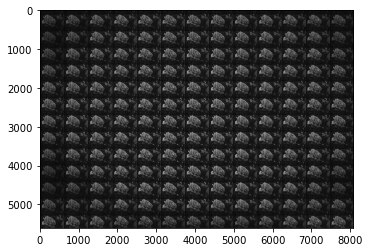

In [6]:


loader = pcam.misc.DataDownloader()
loader.download_data(loader.host_eu_url, fp='./data')
loader.extract_archive(archive_fn='./data/illum_test_data.zip', fname_list='lfr')
lfp_path = './data/gradient_rose_close.lfr'
calibration_path = './data/caldata-B5144402350.tar'
#function call. desired output = decoded_views_all
decoded_views_all = lf_decode_sans_save(lfp_path, calibration_path)
#visualization of results
plt.imshow(decoded_views_all,cmap='gray')
plt.show()

Download skipped as illum_test_data.zip already exists
1
2
3

 Debayering
 Progress: Finished 


 Estimate micro image size
 Progress: Finished 


 Compute LoG
 Progress: Finished 


 Select maxima
 Progress: Finished 


 Refine micro image centers
 Progress: Finished 


 Sort micro image centers
 Progress: Finished 


 Grid fitting
 Progress: Finished 


 Save calibration data
 Progress: Finished 

4

 Hot pixel detection
 Progress: Finished 


 Light-field alignment
 Progress: Finished 


 Save aligned light-field

 Potential data loss as directory already exists.
 Progress: Finished 


 Viewpoint composition
 Progress: Finished 


 Write viewpoint images
 Progress: Finished 



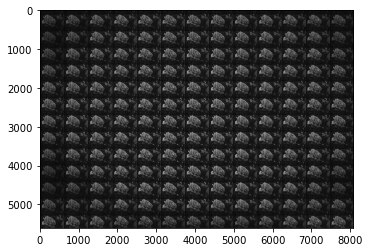

In [12]:
loader = pcam.misc.DataDownloader()
loader.download_data(loader.host_eu_url, fp='./data')
loader.extract_archive(archive_fn='./data/illum_test_data.zip', fname_list='lfr')
lfp_path = './data/gradient_rose_close.lfr'
calibration_path = './data/caldata-B5144402350.tar'
#function call. desired output = decoded_views_all
decoded_views_all = lf_decode_sans_save(lfp_path, calibration_path)
#visualization of results
plt.imshow(decoded_views_all,cmap='gray')
plt.show()